In [1]:
from local_vars import root_folder

data_folder = r"Circles"
image_size = 64
batch_size = 50
input_image_size = 128
input_intensity_scaling = 1 / 255.0

In [2]:
import pandas as pd
import numpy as np
import itertools
import os
import keras

from keras.models import Sequential
from keras.layers import Activation, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.utils import Sequence

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from skimage.io import imread
from skimage.transform import resize

Using TensorFlow backend.


In [3]:
data_fullpath = os.path.join(root_folder, data_folder)
train_fullpath = os.path.join(data_fullpath, "train")
valid_fullpath = os.path.join(data_fullpath, "valid")
test_fullpath = os.path.join(data_fullpath, "test")

print("Training data folder:   {}".format(train_fullpath))
print("Validation data folder: {}".format(valid_fullpath))
print("Test data folder:       {}".format(test_fullpath))

Training data folder:   c:\Temp\Circles\train
Validation data folder: c:\Temp\Circles\valid
Test data folder:       c:\Temp\Circles\test


In [4]:
train_annotations_df = pd.DataFrame()

num_csv_files = 0
for file_name in os.listdir(train_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(train_fullpath, file_name)
    train_annotations_df = pd.concat([train_annotations_df, pd.read_csv(current_file_path)])

valid_annotations_df = pd.DataFrame()

for file_name in os.listdir(valid_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(valid_fullpath, file_name)
    valid_annotations_df = pd.concat([valid_annotations_df, pd.read_csv(current_file_path)])

test_annotations_df = pd.DataFrame()

for file_name in os.listdir(test_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(test_fullpath, file_name)
    test_annotations_df = pd.concat([test_annotations_df, pd.read_csv(current_file_path)])

num_test_images = test_annotations_df.shape[0]
    
print("Number of training images:   {}".format(train_annotations_df.shape[0]))
print("Number of validation images: {}".format(valid_annotations_df.shape[0]))
print("Number of test images:       {}".format(num_test_images))

Number of training images:   10000
Number of validation images: 200
Number of test images:       200


In [56]:
class MyBatchGenerator(Sequence):
    
    def __init__(self, image_filenames, annotations_df, batch_size, image_size=256):
        self.image_filenames, self.annotations_df = image_filenames, annotations_df
        self.batch_size = batch_size
    
    def __len__(self):
        num_batches = np.ceil(len(self.image_filenames) / float(self.batch_size))
        return int(num_batches)
    
    def __getitem__(self, idx):
        from_index = idx * self.batch_size
        to_index = (idx + 1) * self.batch_size
        batch_x = self.image_filenames[from_index:to_index]
        batch_y = self.annotations_df[['class']].iloc[from_index:to_index]
        # batch_y = batch_y / float(input_image_size)
        return np.array([
            resize(
                imread(file_name) * input_intensity_scaling,
                (image_size, image_size, 1),
                anti_aliasing=False,
                preserve_range=True,
                mode='constant') for file_name in batch_x]),  np.array(batch_y)

In [6]:
train_image_filenames = [os.path.join(train_fullpath,fn) for fn in os.listdir(train_fullpath) if fn.endswith('png')]
valid_image_filenames = [os.path.join(valid_fullpath,fn) for fn in os.listdir(valid_fullpath) if fn.endswith('png')]
test_image_filenames = [os.path.join(test_fullpath,fn) for fn in os.listdir(test_fullpath) if fn.endswith('png')]

train_generator = MyBatchGenerator(train_image_filenames, train_annotations_df, batch_size, image_size)
valid_generator = MyBatchGenerator(valid_image_filenames, valid_annotations_df, batch_size, image_size)

In [7]:
from keras.regularizers import l2
weight_decay = 0.001

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [8]:
num_validation_steps = valid_annotations_df.shape[0] // batch_size
num_steps = train_annotations_df.shape[0] // batch_size

print("Training steps:   {}".format(num_steps))
print("Validation steps: {}".format(num_validation_steps))

Training steps:   200
Validation steps: 4


In [9]:
model.compile(Adam(lr=.0001), loss='mse', metrics=['accuracy'])

In [10]:
num_epochs = 8

history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=num_steps,
    epochs=num_epochs,
    verbose=1,
    validation_data=valid_generator,
    validation_steps=num_validation_steps)

Epoch 1/8
200/200 [==============================] - 12s 61ms/step - loss: 0.3238 - acc: 0.4955 - val_loss: 0.3045 - val_acc: 0.5150
Epoch 2/8
200/200 [==============================] - 10s 50ms/step - loss: 0.2912 - acc: 0.5039 - val_loss: 0.2798 - val_acc: 0.5150
Epoch 3/8
200/200 [==============================] - 10s 50ms/step - loss: 0.2721 - acc: 0.5114 - val_loss: 0.2657 - val_acc: 0.4850
Epoch 4/8
200/200 [==============================] - 10s 51ms/step - loss: 0.2614 - acc: 0.5002 - val_loss: 0.2576 - val_acc: 0.5150
Epoch 5/8
200/200 [==============================] - 10s 50ms/step - loss: 0.2546 - acc: 0.5907 - val_loss: 0.2479 - val_acc: 0.8250
Epoch 6/8
200/200 [==============================] - 10s 50ms/step - loss: 0.1530 - acc: 0.8851 - val_loss: 0.0298 - val_acc: 1.0000
Epoch 7/8
200/200 [==============================] - 10s 51ms/step - loss: 0.0248 - acc: 0.9997 - val_loss: 0.0216 - val_acc: 1.0000
Epoch 8/8
200/200 [==============================] - 10s 50ms/step - 

Text(0.5,1,'Accuracy Curves')

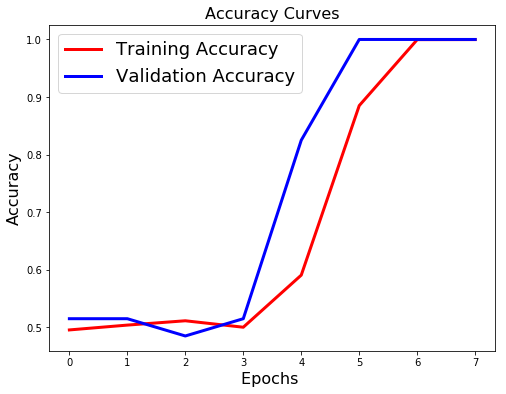

In [11]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [12]:
test_generator = MyBatchGenerator(test_image_filenames, test_annotations_df, num_test_images, image_size)

In [76]:
def plots(ims, ys, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        sp.set_title(str(y[i]), fontsize=16)
        plt.imshow(ims[i][:, :, 0], cmap='gray')
        plt.axvline(x=ys[i][0])
        plt.axhline(y=ys[i][1])
        

def cplots(ims, ys, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(str(titles[i]), fontsize=16)
        plt.imshow(ims[i][:, :], cmap='jet')

In [77]:
from_index = 0
num_test_vis = 12
to_index = from_index + num_test_vis

print("Test index range: {} -- {}".format(from_index, to_index))


x, y = test_generator.__getitem__(0)

y_locs = test_annotations_df[['x_position', 'y_position']].iloc[from_index:to_index].values
y_locs = y_locs / float(input_image_size)

y_pred = np.rint( model.predict(x) )

Test index range: 0 -- 12


In [84]:
from vis.visualization import visualize_cam
from vis.utils import utils

layer_index = utils.find_layer_idx(model, "dense_1")
print("Layer index for CAM = {}".format(layer_index))

heat_map = np.zeros((num_test_images, image_size, image_size), dtype=int)

for i in range(num_test_vis):
    heat_map[i][:,:] = visualize_cam(model, layer_index, None, x[from_index + i])

Layer index for CAM = 12


In [85]:
from numpy import unravel_index

y_pred_locs = np.zeros([n_images, 2])

for i in range(n_images):
    maxindex = unravel_index(heat_map[i][:,:].argmax(), heat_map[i].shape)
    if y_pred[i] == 0:
        y_pred_locs[i] = [0, 0]
    else:
        y_pred_locs[i] = (maxindex[1], maxindex[0])

y_pred_locs = y_pred_locs / float(image_size)

In [86]:
n = len(y_pred_locs)
print("n = {}".format(n))
average_error = 0.0
averaging_factor = 1.0 / n
for i in range(n):
    distance = np.linalg.norm(y_pred_locs[i] - y_locs[i])
    average_error += distance * averaging_factor

print("Average error: {0:.4f}".format(average_error))    

n = 12
Average error: 0.0396


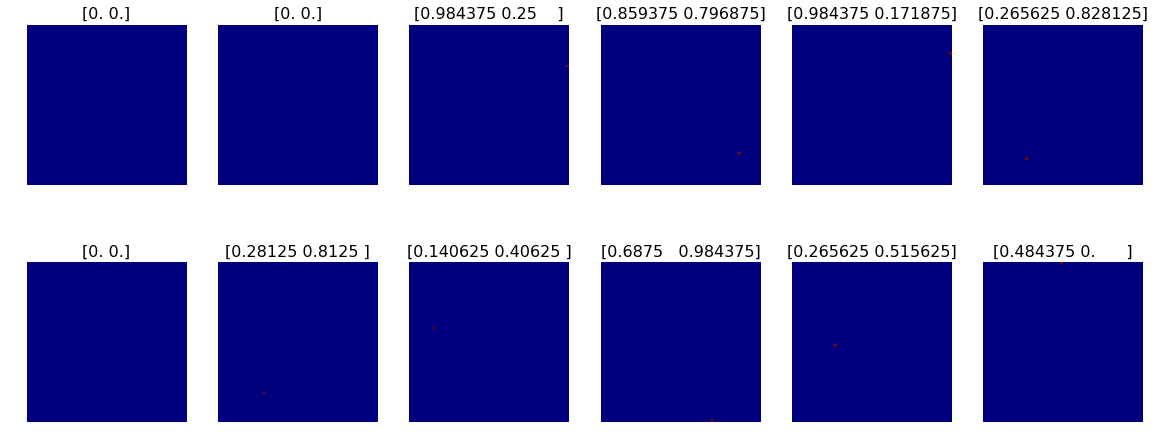

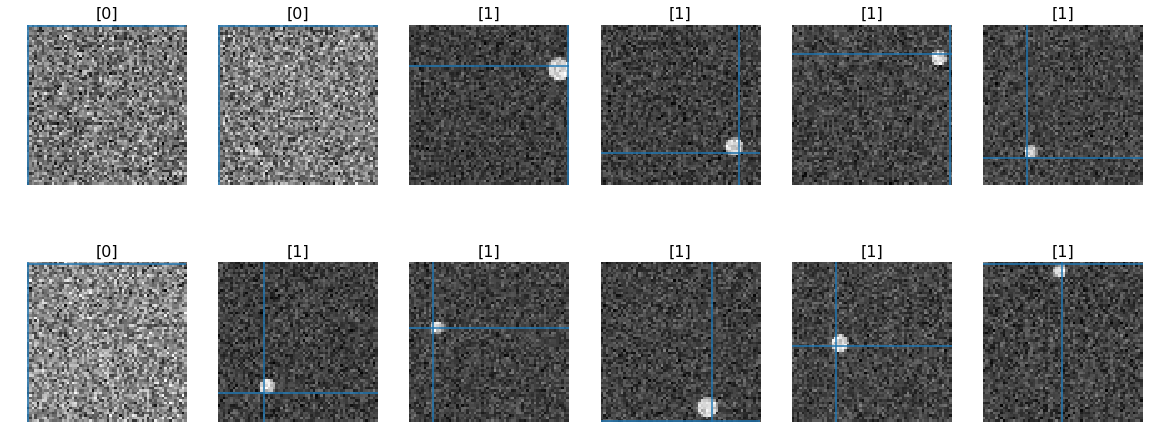

In [87]:
cplots(heat_map[:n_images],
       y[start_index:(start_index + n_images)],
       figsize=(20,8),
       rows=2,
       titles=y_pred_locs)

plots(x[start_index:(start_index + n_images)],
      y_pred_locs[start_index:(start_index + n_images)] * image_size,
      figsize=(20,8),
      rows=2,
      titles=y[start_index:(start_index + n_images)])

In [18]:
# Saving weights into file tagged with timestamp, every time this block runs.

import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

weights_folder = os.path.join(root_folder, "weights")

if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)
    print("Creating folder: {}".format(weights_folder))

weights_file_name = "weights_" + timestamp + ".h5"
weights_file_path = os.path.join(weights_folder, weights_file_name)

model.save_weights(weights_file_path)